In [1]:
# import importlib
# importlib.reload(cluster_util)
# import cluster_util

# Notebook error analysis 

## Refining error types - Vectorization and clustering method selection


use the combined dedupped GitHub + Kaggle error dataset

### Clustering value errors

load tokenized error dataset, evalue_tokenized

In [1]:
import pandas as pd 
import cluster_util, config

df_mlerr_g_mlbugs_unique = pd.read_excel(config.path_github_error_analysis.joinpath("df_mlerr_g_mlbugs_filtered_dedup.xlsx"))
df_mlerr_k_mlbugs_unique = pd.read_excel(config.path_kaggle_error_analysis.joinpath("df_mlerr_k_mlbugs_filtered_dedup.xlsx"))

df_mlerr_mlbugs_unique = pd.concat([df_mlerr_g_mlbugs_unique, df_mlerr_k_mlbugs_unique], ignore_index=True, sort=False)

C:\Users\yirwa29\AppData\Local\anaconda3\envs\chatgpt\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


path_default=WindowsPath('C:/Users/yirwa29/Downloads/Dataset-Nb')


In [2]:
err_descs = df_mlerr_mlbugs_unique['evalue_tokenized'].values.astype('U')
err_descs.shape[0] # 14518

14518

### 1 Vectorization

##### 2. sentence transformers

https://github.com/UKPLab/sentence-transformers

https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2

sentence to vector, dimension -384

different processing

In [4]:
# df_mlerr_mlbugs_unique['evalue_tokenized_transformer'] = df_mlerr_mlbugs_unique['evalue'].apply(cluster_util.preprocess_text_transformer)

# err_descs1 = df_mlerr_mlbugs_unique['evalue_tokenized_transformer'].values.astype('U')
# X_transformers = cluster_util.vectorizer_sentence2vec(err_descs1)

# import numpy as np

# with open(config.path_default.joinpath("df_mlerr_mlbugs_filtered_dedup_embeddings_transformers.txt"), 'wb') as f:
#     np.save(f, X_transformers)

##### 3. fine-tuned subword embeddings

Turn sentences to vectors via word embeddings by taking the mean/sum of all word embeddings of the sentence

the finetuned subword embeddings using gensim.models.fasttext of "wiki.en.bin" pretrained model. dimension 300

In [3]:
# import numpy as np
# import retrain_word2vec,config

# w2v_model = retrain_word2vec.load_word2vec(config.path_w2v_models, "nberr_subword2vec_finetune.model")
# X_wordemb = np.array([cluster_util.vectorizer_word2vec(xi, w2v_model.wv, w2v_model.vector_size) for xi in err_descs])

# with open(config.path_default.joinpath("df_mlerr_mlbugs_filtered_dedup_subwordembeddings.txt"), 'wb') as f:
#     np.save(f, X_wordemb)
    
# X_wordemb.shape # (14518, 300)

(14518, 300)

In [7]:
# this is using GloVe
# import numpy as np

# glove_vectors = cluster_util.load_glove("C:/Users/yirwa29/Downloads/Dataset-Nb/glove.6B/glove.6B.200d.txt")
# X_wordemb = np.array([cluster_util.vectorizer_word2vec(xi, glove_vectors, 200) for xi in err_descs])

# with open(config.path_default.joinpath("df_mlerr_mlbugs_filtered_dedup_embeddings_glove.txt"), 'wb') as f:
#     np.save(f, X_wordemb)
    
# X_wordemb.shape # (14518, 200)

Loaded 400000 word vectors from GloVe.


(14518, 200)

### 2. Clustering with vectorized error values


##### 2. sentence transformers

In [12]:
# #PCA

# import numpy as np

# with open(config.path_default.joinpath("df_mlerr_mlbugs_filtered_dedup_embeddings_transformers.txt"), 'rb') as f:
#     X_transformers = np.load(f)
    
# n_components = cluster_util.select_pca_n_basedon_variance(X_transformers)
# X_transformers_pca = cluster_util.pca(X_transformers, n_components=n_components)

# with open(config.path_default.joinpath("df_mlerr_mlbugs_filtered_dedup_embeddings_transformers_pca.txt"), 'wb') as f:
#     np.save(f, X_transformers_pca)

In [2]:
import numpy as np

with open(config.path_default.joinpath("df_mlerr_mlbugs_filtered_dedup_embeddings_transformers_pca.txt"), 'rb') as f:
    X_transformers_pca = np.load(f)

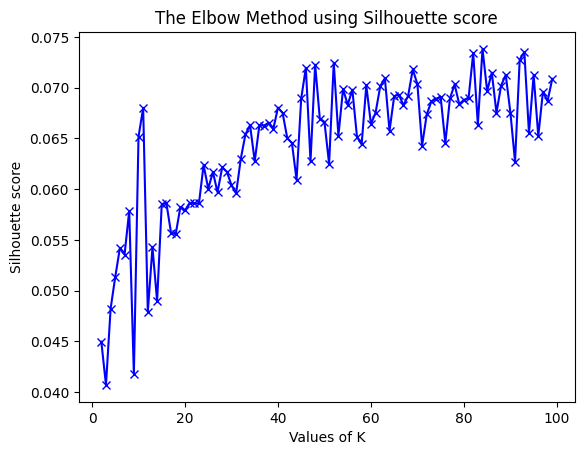

In [9]:
## kmeans

K_range = range(2,100)
inertias = cluster_util.elbow_for_kmean(X_transformers_pca, K_range = K_range)

import matplotlib.pyplot as plt

plt.plot(K_range, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Silhouette score')
plt.title('The Elbow Method using Silhouette score')
plt.show()

In [3]:
num_clusters = 60
res = cluster_util.cluster_kmeans(X_transformers_pca, n_clusters=num_clusters)
df_mlerr_mlbugs_unique.loc[:,"cluster_km_transformers"] = res

In [4]:
## dbscan
eps_transformers = cluster_util.epsilon_search_dbscan(X_transformers_pca)
print(eps_transformers)
res = cluster_util.cluster_dbscan(X_transformers_pca, eps=eps_transformers, min_samples=2)
df_mlerr_mlbugs_unique.loc[:,"cluster_dbscan_transformers"] = res

0.7216190644258098
Estimated no. of clusters: 291
Estimated no. of noise points: 1838


In [5]:
cluster_util.eval_cluster_silhouette(X_transformers_pca[df_mlerr_mlbugs_unique['cluster_dbscan_transformers']!=-1],
                                     df_mlerr_mlbugs_unique.loc[df_mlerr_mlbugs_unique['cluster_dbscan_transformers']!=-1, 'cluster_dbscan_transformers'])

-0.15652737

In [6]:
## OPTICS
res = cluster_util.cluster_optics(X_transformers_pca, min_samples = 2)
df_mlerr_mlbugs_unique.loc[:,"cluster_optics_transformers"] = res

Estimated no. of clusters: 2499
Estimated no. of noise points: 7957


C:\Users\yirwa29\AppData\Local\anaconda3\envs\chatgpt\Lib\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


In [7]:
cluster_util.eval_cluster_silhouette(X_transformers_pca[df_mlerr_mlbugs_unique['cluster_optics_transformers']!=-1],
                                     df_mlerr_mlbugs_unique.loc[df_mlerr_mlbugs_unique['cluster_optics_transformers']!=-1, 'cluster_optics_transformers'])

0.37598422

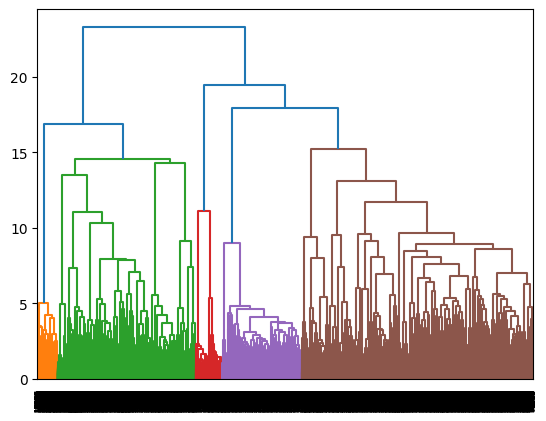

In [16]:
# hierarchical - AgglomerativeClustering
from scipy.cluster import hierarchy as shc

Dendrogram = shc.dendrogram((shc.linkage(X_transformers_pca, method ='ward')))

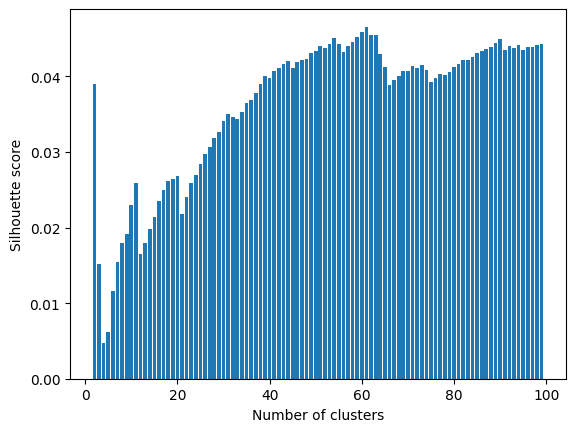

In [18]:
import matplotlib.pyplot as plt

ks = range(2,100)
silhouette_scores_transformer = []
for k in ks:
    model = cluster_util.cluster_agglomerative(X_transformers_pca, n_clusters=k)
    silhouette_scores_transformer.append(cluster_util.eval_cluster_silhouette(X_transformers_pca, model.labels_))

# plot
plt.bar(ks, silhouette_scores_transformer)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()

In [11]:
# outputs the structure of the tree
model = cluster_util.cluster_agglomerative(X_transformers_pca, n_clusters=2) #model.labels_
root = cluster_util.aggcluster_to_tree(model)

In [17]:
# import pickle

with open(config.path_default.joinpath("aggmodel_transformer.pkl"), "wb") as f:
    pickle.dump(model, f)
with open(config.path_default.joinpath("aggroot_transformer.pkl"), "wb") as f:
    pickle.dump(root, f)

In [18]:
# import pickle

# with open(config.path_default.joinpath("aggroot_transformer.pkl"), "rb") as f:
#     root = pickle.load(f)

##### 3. word embeddings

In [4]:
# #PCA

# import numpy as np

# with open(config.path_default.joinpath("df_mlerr_mlbugs_filtered_dedup_subwordembeddings.txt"), 'rb') as f:
#     X_wordemb = np.load(f)
    
# n_components = cluster_util.select_pca_n_basedon_variance(X_wordemb)
# X_wordemb_pca = cluster_util.pca(X_wordemb, n_components=n_components)

# with open(config.path_default.joinpath("df_mlerr_mlbugs_filtered_dedup_subwordembeddings_pca.txt"), 'wb') as f:
#     np.save(f, X_wordemb_pca)

pca: 130 components can explain 80.10% variance of the data


In [8]:
import numpy as np

with open(config.path_default.joinpath("df_mlerr_mlbugs_filtered_dedup_subwordembeddings_pca.txt"), 'rb') as f:
    X_wordemb_pca = np.load(f)

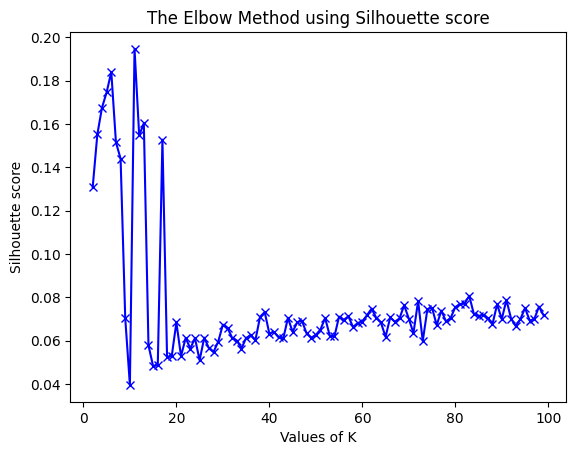

In [20]:
## kmeans
K_range = range(2,100)
inertias = cluster_util.elbow_for_kmean(X_wordemb_pca, K_range = K_range)

import matplotlib.pyplot as plt

plt.plot(K_range, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Silhouette score')
plt.title('The Elbow Method using Silhouette score')
plt.show()

In [5]:
num_clusters = 60
res = cluster_util.cluster_kmeans(X_wordemb_pca, n_clusters=num_clusters)
df_mlerr_mlbugs_unique.loc[:,"cluster_km_wordemb"] = res

In [6]:
cluster_util.eval_cluster_silhouette(X_wordemb_pca, df_mlerr_mlbugs_unique['cluster_km_wordemb'])

0.05935105674844975

In [7]:
## dbscan
eps_wordemb = cluster_util.epsilon_search_dbscan(X_wordemb_pca)
print(eps_wordemb)
res = cluster_util.cluster_dbscan(X_wordemb_pca, eps=eps_wordemb, min_samples=2)
df_mlerr_mlbugs_unique.loc[:,"cluster_dbscan_wordemb"] = res

1.198428790424666
Estimated no. of clusters: 628
Estimated no. of noise points: 3709


In [8]:
cluster_util.eval_cluster_silhouette(X_wordemb_pca[df_mlerr_mlbugs_unique['cluster_dbscan_wordemb']!=-1],
                                     df_mlerr_mlbugs_unique.loc[df_mlerr_mlbugs_unique['cluster_dbscan_wordemb']!=-1, 'cluster_dbscan_wordemb'])

0.047860742378380415

In [9]:
## OPTICS
res = cluster_util.cluster_optics(X_wordemb_pca, min_samples = 2)
df_mlerr_mlbugs_unique.loc[:,"cluster_optics_wordemb"] = res

Estimated no. of clusters: 2079
Estimated no. of noise points: 9094


C:\Users\yirwa29\AppData\Local\anaconda3\envs\chatgpt\Lib\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


In [10]:
cluster_util.eval_cluster_silhouette(X_wordemb_pca[df_mlerr_mlbugs_unique['cluster_optics_wordemb']!=-1],
                                     df_mlerr_mlbugs_unique.loc[df_mlerr_mlbugs_unique['cluster_optics_wordemb']!=-1, 'cluster_optics_wordemb'])

0.4466233209881664

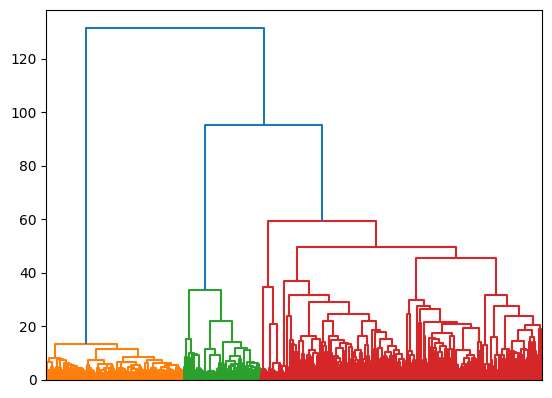

In [22]:
# hierarchical - AgglomerativeClustering
from scipy.cluster import hierarchy as shc

Dendrogram = shc.dendrogram((shc.linkage(X_wordemb_pca, method ='ward')), no_labels=True)

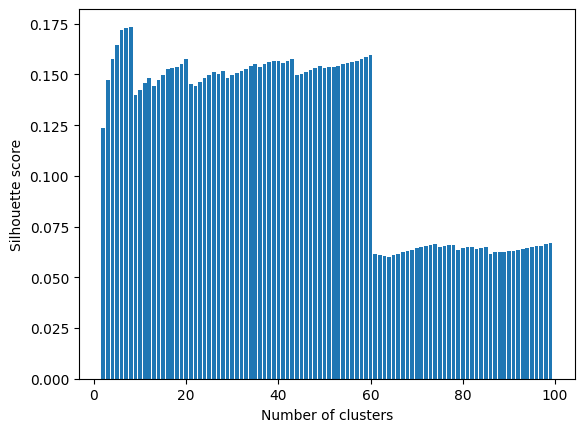

In [21]:
import matplotlib.pyplot as plt

ks = range(2,100)
silhouette_scores_wordemb = []
for k in ks:
    model = cluster_util.cluster_agglomerative(X_wordemb_pca, n_clusters=k)
    silhouette_scores_wordemb.append(cluster_util.eval_cluster_silhouette(X_wordemb_pca, model.labels_))

# plot
plt.bar(ks, silhouette_scores_wordemb)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()

In [29]:
# outputs the structure of the tree
model = cluster_util.cluster_agglomerative(X_wordemb_pca, n_clusters=2) #model.labels_
root = cluster_util.aggcluster_to_tree(model)

import pickle

# with open(config.path_default.joinpath("aggmodel_wordemb.pkl"), "wb") as f:
#     pickle.dump(model, f)
# with open(config.path_default.joinpath("aggroot_wordemb.pkl"), "wb") as f: # maximum recursion depth exceeded
#     pickle.dump(root, f) 

In [27]:
silhouette_scores_wordemb[58:60] # big drop at 61 clusters

[0.1596855216205519, 0.061637771364496496]

In [18]:
df_mlerr_mlbugs_unique.to_excel(config.path_default.joinpath("df_mlerr_mlbugs_filtered_dedup_clustered.xlsx"), index=False, engine='xlsxwriter')

In [6]:
import pickle

with open(config.path_default.joinpath("aggmodel_wordemb.pkl"), "rb") as f:
    model_load = pickle.load(f)
root = cluster_util.aggcluster_to_tree(model_load)

In [ ]:
from bigtree import levelorder_iter

res_nodes = []

for node in levelorder_iter(root):
    if len(list(node.leaves)) in range(20,60): # check node size within a range
        res_nodes.append(node)

In [ ]:
import random
#take the last one for example
res_names = [leave_node.node_name-1 for leave_node in res_nodes[random.randint(0,len(res_nodes))].leaves]
# see what are they
for i in df_mlerr_mlbugs_unique.iloc[res_names].evalue:
    print("==>",i)

In [ ]:
df_mlerr_mlbugs_unique.iloc[res_names]

In [ ]:
df_mlerr_mlbugs_unique.iloc[res_names].evalue_tokenized

In [ ]:
nk = 80
# print(silhouette_scores_tfidf[nk-2])
# print(silhouette_scores_transformers[nk-2])
print(silhouette_scores_wordemb[nk-2])

In [ ]:
# LDA, Latent Dirichlet Allocation
# LDA works off the premise that documents with the same topic will have a lot of words in common.
# LDA is a bag of words model meaning that it only considers individual tokens and not their relationships in a sentence.
